/home/workstation/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/workstation/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 4563/4563 [01:20<00:00, 56.40it/s]
/home/workstation/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

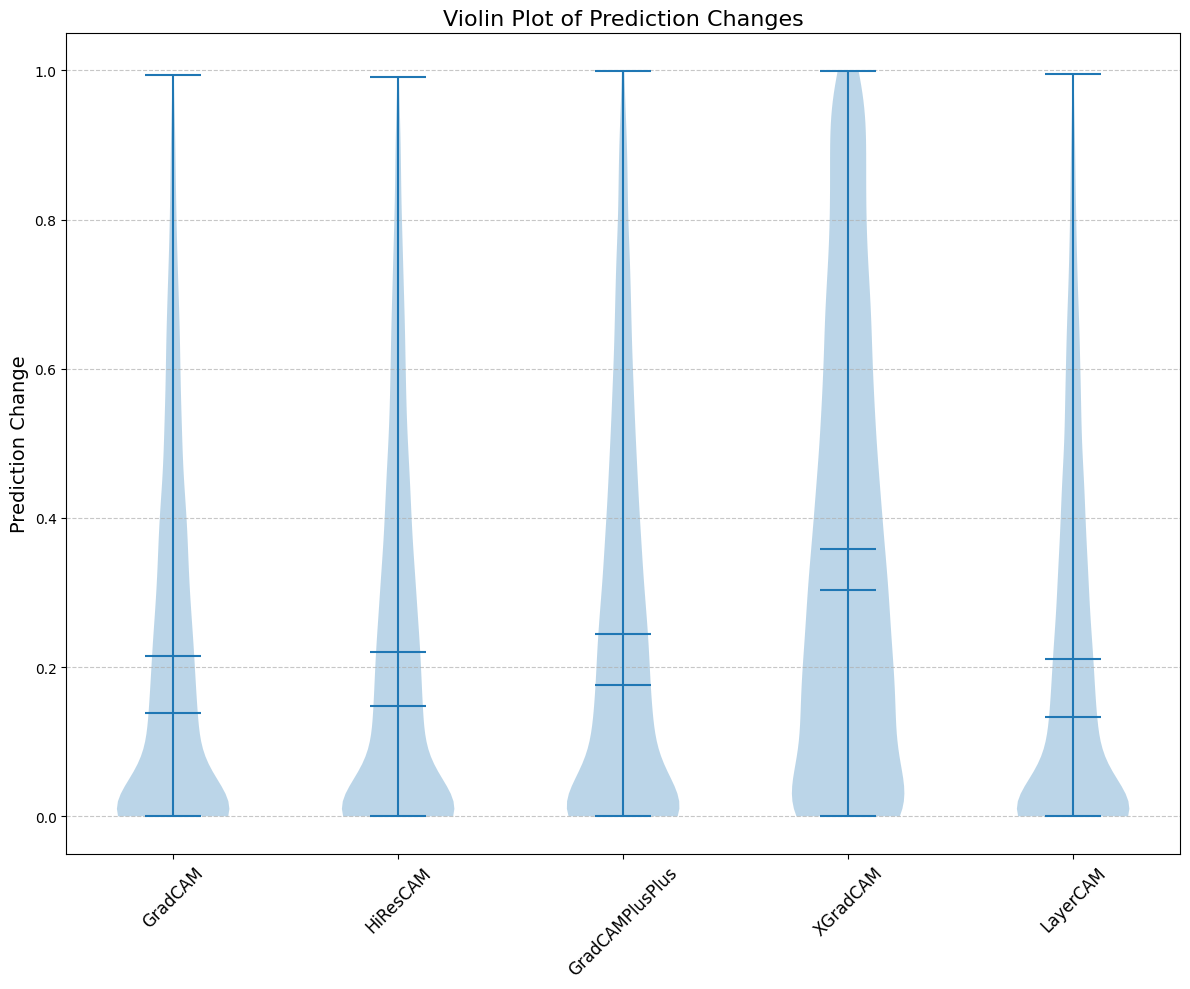

In [1]:
import os
from PIL import Image
import json
from torchvision import transforms
import torch
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from torchvision.models import resnet50
import matplotlib.pyplot as plt

import numpy as np


def write_to_txt(filepath, content):
    with open(filepath, "w") as file:
        file.write(content)

def load_images_from_directory(root_path: str):
    dataset = []
    for label_folder in os.listdir(root_path):
        parts = label_folder.split('_')
        image_id = '_'.join(parts[:-1]) 
        image_label = parts[-1]  
        dataset.append((image_id, image_label))
    return dataset


def calculate_prediction_changes(original_scores, masked_scores, top_n_indices):
    idx = top_n_indices[0]
    original_score = original_scores[idx]
    masked_score = masked_scores[idx]
    change = max(0, original_score - masked_score)
    if original_score > 0:
        percentage = change / original_score
    elif original_score < 0:
        percentage = change / abs(original_score)
    else:
        percentage = 0
    return change, percentage

CAM_ALGORITHMS = ["GradCAM", "HiResCAM", "GradCAMPlusPlus", "XGradCAM", "LayerCAM"]


current_dir = "/home/workstation/code/XAImethods/CAIN"
all_changes = {}

attack_name = "gaussian_noise/2_ResNet"

results_directory = f"{current_dir}/evaluation/prediction_changes/{attack_name}"
os.makedirs(results_directory, exist_ok=True)

for CAM_Algorithm in CAM_ALGORITHMS:
    dataset_path = f"{current_dir}/results/imagenet/val_images10k_attack/{attack_name}/resnet50/{CAM_Algorithm}"
    dataset = load_images_from_directory(dataset_path)

    with open(f"{current_dir}/imagenet/imagenet_class_index.json", "r") as f:
        imagenet_class_index = json.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    label_to_index_description = {v[0]: (k, v[1]) for k, v in imagenet_class_index.items()}
    model = resnet50(pretrained=True).to(device)

    model.eval()

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), normalize])


    def ensure_rgb(img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

    results_path = os.path.join(results_directory, f"{CAM_Algorithm}.txt")

    true_labels = []
    predicted_labels_original = []
    predicted_labels_masked = []
    changes = []
    percentages = []
    for image_id, label in tqdm(dataset):
        original_img_path = os.path.join(dataset_path, image_id + "_" + label, 'original.jpg')
        masked_img_path = os.path.join(dataset_path, image_id + "_" + label, 'masked_image.jpg')

        original_img = ensure_rgb(Image.open(original_img_path))
        original_img_tensor = transform(original_img).to(device)

        masked_img = ensure_rgb(Image.open(masked_img_path))
        masked_img_tensor = transform(masked_img).to(device)

        with torch.no_grad():
            original_logits = model(original_img_tensor.unsqueeze(0))


            original_scores = torch.nn.functional.softmax(original_logits, dim=1).squeeze().tolist()
            predicted_label_original = torch.argmax(original_logits, dim=1).item()

            masked_logits = model(masked_img_tensor.unsqueeze(0))


            masked_scores = torch.nn.functional.softmax(masked_logits, dim=1).squeeze().tolist()
            predicted_label_masked = torch.argmax(masked_logits, dim=1).item()
        
        top_n_indices = [predicted_label_original]
        change, percentage = calculate_prediction_changes(original_scores, masked_scores, top_n_indices)
        changes.append(change)
        percentages.append(percentage)

        

        index_str, _ = label_to_index_description.get(label, (None, None))
        if index_str is None:
            continue
        true_label = int(index_str)
        true_labels.append(true_label)
        predicted_labels_original.append(predicted_label_original)
        predicted_labels_masked.append(predicted_label_masked)

    precision_original, recall_original, f1_original, _ = precision_recall_fscore_support(true_labels, predicted_labels_original, average='macro')
    precision_masked, recall_masked, f1_masked, _ = precision_recall_fscore_support(true_labels, predicted_labels_masked, average='macro')
    
    mean_changes = np.mean(changes)
    mean_percentages = np.mean(percentages)
    q25_changes = np.percentile(changes, 25)
    median_changes = np.median(changes)
    q75_changes = np.percentile(changes, 75)
    q25_percentages = np.percentile(percentages, 25)
    median_percentages = np.median(percentages)
    q75_percentages = np.percentile(percentages, 75)

    results = [
        f"--- Original Dataset ---\n",
        f"Precision: {precision_original:.4f}\n",
        f"Recall: {recall_original:.4f}\n",
        f"F1 Score: {f1_original:.4f}\n",
        f"--- Masked Dataset ---\n",
        f"Precision: {precision_masked:.4f}\n",
        f"Recall: {recall_masked:.4f}\n",
        f"F1 Score: {f1_masked:.4f}\n",
        f"\n--- Prediction Changes ---\n",
        f"Average Change: {mean_changes:.4f}\n",
        f"Average Percentage Change: {mean_percentages:.4f}\n",
        f"Q25 Change: {q25_changes:.4f}\n",
        f"Median Change: {median_changes:.4f}\n",
        f"Q75 Change: {q75_changes:.4f}\n",
        f"Q25 Percentage Change: {q25_percentages:.4f}\n",
        f"Median Percentage Change: {median_percentages:.4f}\n",
        f"Q75 Percentage Change: {q75_percentages:.4f}\n"
    ]
    

    all_changes[CAM_Algorithm] = changes

    write_to_txt(results_path, ''.join(results))

# Plotting the violin plots for prediction changes

plt.figure(figsize=(12, 10))
plt.violinplot([all_changes[cam] for cam in CAM_ALGORITHMS], showmeans=True, showmedians=True)
plt.title("Violin Plot of Prediction Changes", fontsize=16)
plt.ylabel("Prediction Change", fontsize=14)
plt.ylim(min(min(all_changes[cam]) for cam in CAM_ALGORITHMS) - 0.05, max(max(all_changes[cam]) for cam in CAM_ALGORITHMS) + 0.05)

# Use the CAM_ALGORITHMS names for the x-axis labels
plt.xticks(np.arange(1, len(CAM_ALGORITHMS) + 1), CAM_ALGORITHMS, fontsize=12, rotation=45)  # Added rotation for better visibility

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(results_directory, "violin_plot_prediction_changes.png"), dpi=300)  # Save the figure before showing
plt.show()


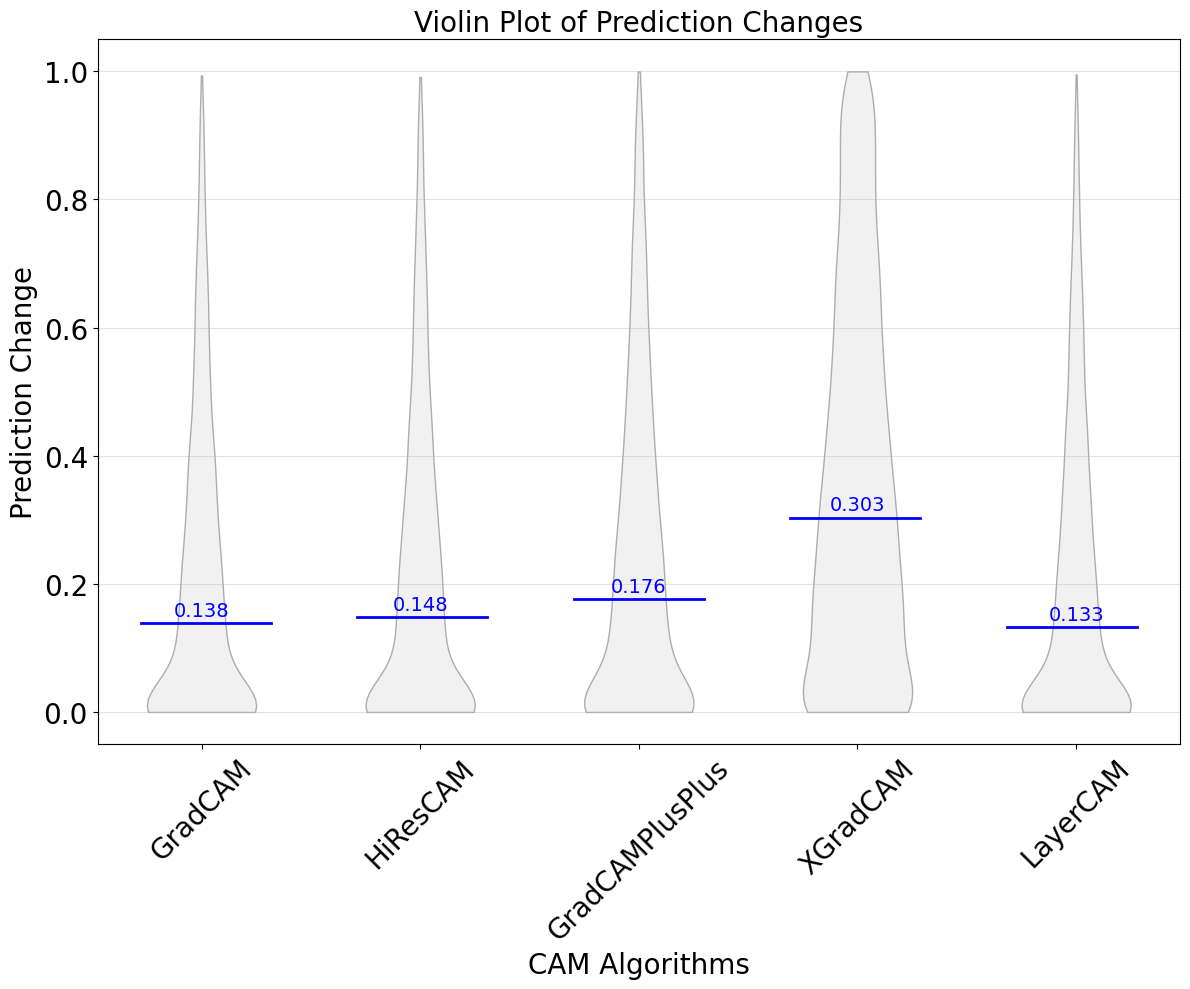

In [3]:
plt.figure(figsize=(12, 10))
violins = plt.violinplot([all_changes[cam] for cam in CAM_ALGORITHMS], showmeans=False, showmedians=False, showextrema=False)
plt.title("Violin Plot of Prediction Changes", fontsize=20)
plt.ylabel("Prediction Change", fontsize=20)
plt.xlabel("CAM Algorithms", fontsize=20)

# Color the violin bodies
for body in violins['bodies']:
    body.set_facecolor('#D3D3D3')  # Light gray color for the violin body
    body.set_edgecolor('black')    # Black edge color for the violin body

# Highlight medians
medians = [np.median(all_changes[cam]) for cam in CAM_ALGORITHMS]
for i, median in enumerate(medians, 1):
    plt.axhline(y=median, color='blue', linewidth=2, xmin=(i-1+0.2)/len(medians), xmax=(i-0.2)/len(medians))
    plt.text(i, median + 0.02, f"{median:.3f}", color='blue', va='center', ha='center', fontsize=14)  # Adjust y-value for text positioning if needed

# Use the CAM_ALGORITHMS names for the x-axis labels with increased fontsize
plt.xticks(np.arange(1, len(CAM_ALGORITHMS) + 1), CAM_ALGORITHMS, fontsize=14, rotation=45)  # Increased fontsize

# Increase the fontsize of x and y tick labels
plt.tick_params(axis='both', which='major', labelsize=20)

plt.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(results_directory, "violin_plot_prediction_changes.png"), dpi=300)
plt.show()
